# Setup

In [1]:
import pandas as pd
import re
import seaborn as sns

# Data Preparation 
Read scraped data

In [2]:
df =  pd.read_csv('Data_Boliga_20220208.csv')

df.head()

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5.000.000 kr.,17-01-2022,Alm. Salg,93 m²,53.763 kr/m²,3 2007 -5% Aktuel værdi
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8.495.000 kr.,14-01-2022,Alm. Salg,170 m²,49.971 kr/m²,6 1929 Aktuel værdi
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5.400.000 kr.,14-01-2022,Alm. Salg,105 m²,51.429 kr/m²,3 1863 -2% Aktuel værdi
3,E,"Badensgade 48, 2",2300 København S,7.200.000 kr.,14-01-2022,Alm. Salg,65 m²,110.769 kr/m²,3 1899 Aktuel værdi
4,E,"Badensgade 48, 1",2300 København S,7.200.000 kr.,14-01-2022,Alm. Salg,79 m²,91.139 kr/m²,3 1899 Aktuel værdi


## Initial filter

Keep only observations for apartments which was soled as "almindelig salg".

In [3]:
print(df.shape)

df = df[(df['Type'] == 'E') & (df['SellType'] == 'Alm. Salg')]

print(df.shape)

(54793, 9)
(40673, 9)


## Transform data

### Text to numeric

In [4]:
df['Price'] = df['Price'].str.replace('.', '', regex = True).str.replace('kr', '', regex = True)
df['Size'] = df['Size'].str.extract('(\d+)')
df['Price_m2']  = df['Price_m2'].str.replace('.', '', regex = True).str.extract('(\d+)')
df[['Rooms', 'YearBuilt', 'PriceChange']] =  df['Rooms_YearBuilt_PriceChange'].str.split(' ', expand = True).iloc[:,0:3]
df.loc[df['PriceChange'] == 'Aktuel', ['PriceChange']] = '0'
df['PriceChange'] = df['PriceChange'].str.replace('%', '', regex  =True)

df['PostalCode'] = df['Area'].str.extract('(\d{4})')
df['AreaName'] = df['Area'].str.extract('(\D+)')

# Check first rows
df.head()


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange,Rooms,YearBuilt,PriceChange,PostalCode,AreaName
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,17-01-2022,Alm. Salg,93,53763,3 2007 -5% Aktuel værdi,3,2007,-5,2100,København Ø
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,14-01-2022,Alm. Salg,170,49971,6 1929 Aktuel værdi,6,1929,0,2100,København Ø
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,14-01-2022,Alm. Salg,105,51429,3 1863 -2% Aktuel værdi,3,1863,-2,2200,København N
3,E,"Badensgade 48, 2",2300 København S,7200000,14-01-2022,Alm. Salg,65,110769,3 1899 Aktuel værdi,3,1899,0,2300,København S
4,E,"Badensgade 48, 1",2300 København S,7200000,14-01-2022,Alm. Salg,79,91139,3 1899 Aktuel værdi,3,1899,0,2300,København S


Convert numeric columns from characters to numeric. Note the change for a row there an incorrect value had been registered for price change.

In [5]:
# Correct value
df.loc[df['PriceChange'] == '299.499.900', 'PriceChange'] = 0 

# Creat list with columns to convert
num_cols = ['Price', 'Size', 'Price_m2', 'Rooms', 'YearBuilt', 'PriceChange', 'PostalCode']

# Loop over list
for col in num_cols:
    
    df[col] = df[col].astype(int)
    
# Check data types
print(df.dtypes)

Type                           object
StreetAddress                  object
Area                           object
Price                           int32
Date                           object
SellType                       object
Size                            int32
Price_m2                        int32
Rooms_YearBuilt_PriceChange    object
Rooms                           int32
YearBuilt                       int32
PriceChange                     int32
PostalCode                      int32
AreaName                       object
dtype: object


### Floor number

Create variable for the floor number of the apartment by extracting the number from street address column, "st" stands for ground floor.

In [6]:
df['Floor'] = df['StreetAddress'].str.extract(', (\d+|st)')
df.loc[df['Floor'] == 'st', 'Floor'] = 0

Check if any null values appeared for the floor number.

In [7]:
df_floor_null = df[df['Floor'].isnull()]

print(df_floor_null.shape)

df_floor_null.head(15)

(433, 15)


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms_YearBuilt_PriceChange,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor
48,E,Overbys Allé 1A,2500 Valby,7550000,05-01-2022,Alm. Salg,121,62397,6 1900 -6% Aktuel værdi,6,1900,-6,2500,Valby,NaN
398,E,Strandgade 10A,1401 København K,11200000,01-12-2021,Alm. Salg,216,51852,5 1720 Aktuel værdi,5,1720,0,1401,København K,NaN
647,E,Øresundsvej 132D,2300 København S,6995000,13-11-2021,Alm. Salg,132,52992,4 1934 Aktuel værdi,4,1934,0,2300,København S,NaN
724,E,Norgesmindevej 35,2900 Hellerup,11350000,10-11-2021,Alm. Salg,223,50897,5 1908 Aktuel værdi,5,1908,0,2900,Hellerup,NaN
777,E,Kirkebjerg Allé 38,2720 Vanløse,2555000,07-11-2021,Alm. Salg,59,43305,2 1903 -2% Aktuel værdi,2,1903,-2,2720,Vanløse,NaN
862,E,Øresundsvej 132C,2300 København S,5995000,02-11-2021,Alm. Salg,132,45417,4 1934 Aktuel værdi,4,1934,0,2300,København S,NaN
992,E,Prøvestens Allé 3A,2300 København S,2870000,27-10-2021,Alm. Salg,74,38784,2 1900 -4% Aktuel værdi,2,1900,-4,2300,København S,NaN
1586,E,Rosenvængets Allé 5A,2100 København Ø,3750000,28-09-2021,Alm. Salg,59,63559,2 1875 Aktuel værdi,2,1875,0,2100,København Ø,NaN
1812,E,Øresundsvej 126A,2300 København S,2895000,21-09-2021,Alm. Salg,54,53611,2 1920 -3% Aktuel værdi,2,1920,-3,2300,København S,NaN
1865,E,Constantin Hansens Gade 8C,1799 København V,3120000,19-09-2021,Alm. Salg,42,74286,1 2019 -2% Aktuel værdi,1,2019,-2,1799,København V,NaN


There are 433 observations where a floor number can not be extracted. A quick check on some of the addresses shows that the type column is either coded incorrectly or the observations is an apartment located in a villa. Keep the obersvations for now, setting the floor variable to -1 for easy identification later.

In [8]:
df.loc[df['Floor'].isnull(), 'Floor'] = -1

df['Floor'] = df['Floor'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40673 entries, 0 to 54792
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Type                         40673 non-null  object
 1   StreetAddress                40673 non-null  object
 2   Area                         40673 non-null  object
 3   Price                        40673 non-null  int32 
 4   Date                         40673 non-null  object
 5   SellType                     40673 non-null  object
 6   Size                         40673 non-null  int32 
 7   Price_m2                     40673 non-null  int32 
 8   Rooms_YearBuilt_PriceChange  40673 non-null  object
 9   Rooms                        40673 non-null  int32 
 10  YearBuilt                    40673 non-null  int32 
 11  PriceChange                  40673 non-null  int32 
 12  PostalCode                   40673 non-null  int32 
 13  AreaName                     40

## Select relevant columns

Drop redundant columns

In [9]:
df.drop(['Rooms_YearBuilt_PriceChange', 'Type', 'SellType', 'Area'], inplace = True, axis = 1)

## Filter data

Check summary statistics

In [10]:
df.describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Floor
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463,2.179136
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450,1.933333
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000,-1.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000,1.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000,2.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000,3.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000,29.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>,
        <AxesSubplot:title={'center':'Floor'}>, <AxesSubplot:>]],
      dtype=object)

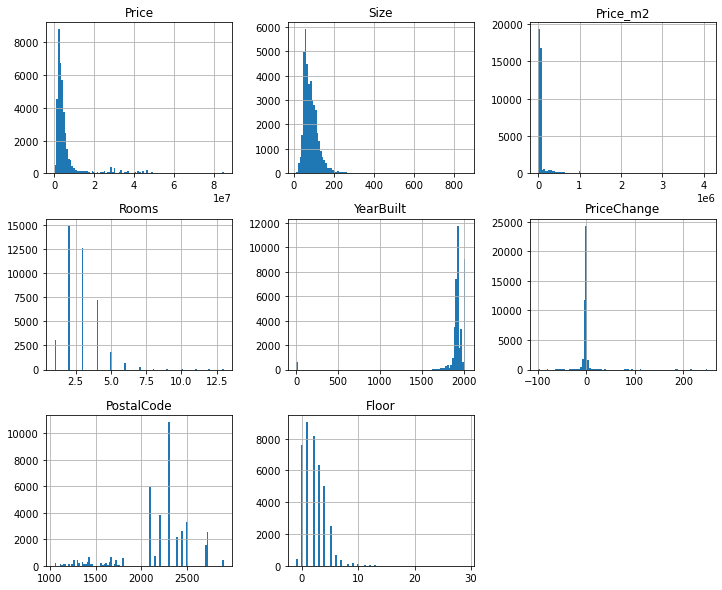

In [11]:
df.hist(bins=100, figsize=(12,10))

### Price

First, for the sake of this project, which is to try to come up with a model to predict values for "regular" apartments, there is a need to filter out the most extreme observations. Therefore, only apartments with a maximum price of 15 m. DKK is used. This might later be changed.

There seems to be quite some spread in the variables, for example a maximum price of 85,000,000 DKK or a maximum size of 857 square meters. Besides, the YearBuilt variable seems to have some strange values, since it says year 0. Let's to plot the relationship between price and size.

<AxesSubplot:xlabel='Size', ylabel='Price'>

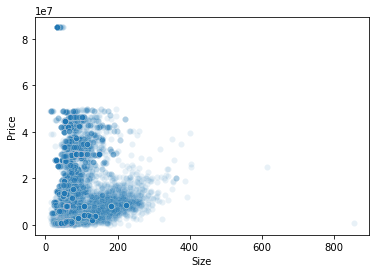

In [12]:
sns.scatterplot(data = df,
            x = 'Size',
            y = 'Price',
            alpha = 0.1)

The horizontal lines looks odd, especially considering it appears for the most expensive. Let's look more into those observations.

In [13]:
df.loc[df['Price'] > 80000000].head(10)

,StreetAddress,Price,Date,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor
42052,"Store Kongensgade 100, 5. 13",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,5
42053,"Store Kongensgade 100, 3. 4",85000000,16-01-2017,39,2179487,1,1970,0,1264,København K,3
42054,"Store Kongensgade 100, 5. 8",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,5
42055,"Store Kongensgade 100, 3. 5",85000000,16-01-2017,33,2575758,1,1970,0,1264,København K,3
42056,"Store Kongensgade 100, 2. 2",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,2
42057,"Store Kongensgade 100, 3. 1",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,3
42058,"Store Kongensgade 100, 2. 8",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,2
42059,"Store Kongensgade 100, 6. 3",85000000,16-01-2017,49,1734694,2,1970,0,1264,København K,6
42060,"Store Kongensgade 100, 3. 2",85000000,16-01-2017,32,2656250,1,1970,0,1264,København K,3
42061,"Store Kongensgade 100, 2. 13",85000000,16-01-2017,31,2741936,1,1970,0,1264,København K,2


It seems like these are apartments bought in larger housing investments, which is probably the case for the other data points on the horizontal lines as well. By counting number of observations by street address, excluding floor and apartment, price, and date, I can find similar instances, which most probably are not private acqusitions.

In [14]:
df['Street'] = df['StreetAddress'].str.split(',').str[0]

df_mult_out = (df.groupby(['Price', 'Date', 'Street'])['Price'].size()
               .sort_values(ascending = False)
               .reset_index(name = 'Count')
               .query('Count >= 2')
              )

df_mult_out.head(10)

,Price,Date,Street,Count
0,8350000,02-01-2015,Esromgade 26,184
1,28101990,14-08-2018,Amagerfælledvej 62A,118
2,28101990,14-08-2018,Amagerfælledvej 62B,115
3,28101990,14-08-2018,Amagerfælledvej 62C,104
4,85000000,16-01-2017,Store Kongensgade 100,72
5,30500000,07-01-2015,Lergravsvej 36,57
6,3995000,06-03-2018,Husumgade 12,38
7,25500000,01-10-2015,Strandlodsvej 5A,37
8,30500000,07-01-2015,Lergravsvej 34,35
9,30500000,07-01-2015,Lergravsvej 32,35


Lets filter out the observations being part of these investments, check how many observations that are filtered out. 

In [15]:
print(df_mult_out['Count'].sum())

# Join number of counts to original data frame nad filter out rows 
df = (
    df.merge(
    df_mult_out,
    how = 'left',
    on = ['Price', 'Date', 'Street'])
    .query('Count.isna()', engine = 'python')
)

print(df.shape)
df.head()

df.drop('Count', inplace = True)

7213
(33460, 13)


,StreetAddress,Price,Date,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor,Street,Count
0,"Amerika Plads 6, 3. th",5000000,17-01-2022,93,53763,3,2007,-5,2100,København Ø,3,Amerika Plads 6,NaN
1,"Strandvejen 8, 3. tv",8495000,14-01-2022,170,49971,6,1929,0,2100,København Ø,3,Strandvejen 8,NaN
2,"Nørrebrogade 9F, 1. th",5400000,14-01-2022,105,51429,3,1863,-2,2200,København N,1,Nørrebrogade 9F,NaN
6,"Nattergalevej 52, 1. tv",2895000,14-01-2022,54,53611,2,1937,0,2400,København NV,1,Nattergalevej 52,NaN
7,"Sorrentovej 14, 1. tv",2330000,14-01-2022,52,44808,2,1940,-2,2300,København S,1,Sorrentovej 14,NaN


Filter out observations above 10 m. DKK

In [21]:
max_price = 15000000

# Number of observations filter out for max price
print(df[df['Price'] > max_price].shape)

df = df[df['Price'] <= max_price]

(201, 13)


Check summary statistics and 

              Price          Size       Price_m2         Rooms     YearBuilt  \
count  3.325900e+04  33259.000000   33259.000000  33259.000000  33259.000000   
mean   3.527088e+06     83.227878   41521.643375      2.773475   1922.698608   
std    2.001634e+06     34.956089   13587.942149      1.067584    207.617720   
min    5.500000e+04     16.000000     457.000000      1.000000      0.000000   
25%    2.100000e+06     57.000000   33505.000000      2.000000   1907.000000   
50%    3.000000e+06     75.000000   40404.000000      3.000000   1936.000000   
75%    4.400000e+06    101.000000   48111.000000      3.000000   1989.000000   
max    1.500000e+07    857.000000  467742.000000     12.000000   2021.000000   

        PriceChange    PostalCode         Floor  Count  
count  33259.000000  33259.000000  33259.000000    0.0  
mean      -1.387865   2190.596951      2.252563    NaN  
std        4.185806    376.013230      1.959651    NaN  
min      -99.000000   1051.000000     -1.000000    

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'Count'}>]], dtype=object)

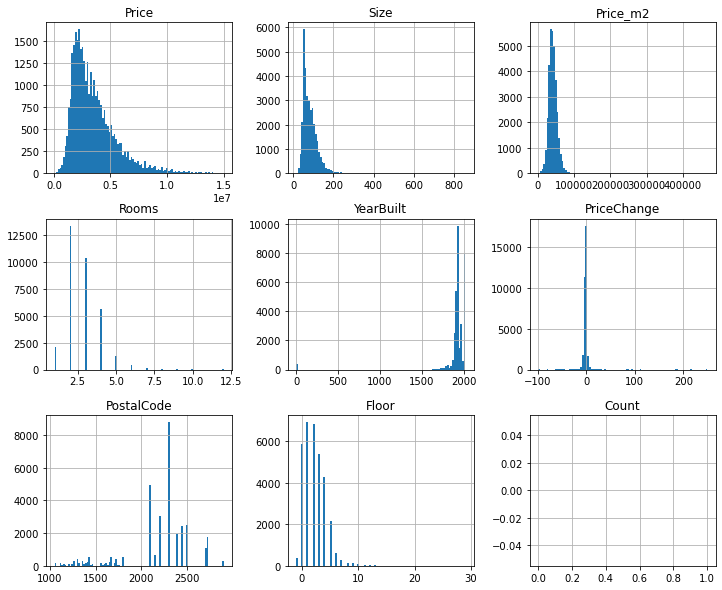

In [22]:
print(df.describe())

df.hist(bins=100, figsize=(12,10))

### Size

There still seem to be some outliers with regards to size. Check observations with size above 200 m2.

<AxesSubplot:>

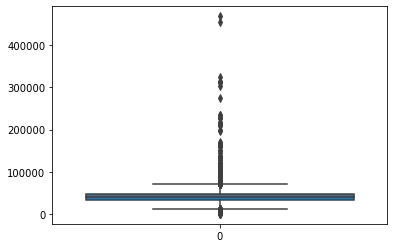

In [38]:
sns.boxplot(data = df['Price_m2'])

In [46]:
df[df['Price_m2'] < 1000]

,StreetAddress,Price,Date,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor,Street,Count,Price_m2_norm
7243,"Reykjaviksgade 1, 1. th",60000,18-12-2020,116,517,4,1907,-99,2300,København S,1,Reykjaviksgade 1,NaN,-1.732129
11407,"Gamle Carlsberg Vej 13, st. 7",105000,22-06-2020,230,457,8,1853,0,1799,København V,0,Gamle Carlsberg Vej 13,NaN,-1.709647
12915,"Rådmandsgade 60, 1",720000,18-03-2020,857,840,5,1934,0,2200,København N,1,Rådmandsgade 60,NaN,-1.402398


<AxesSubplot:xlabel='Size', ylabel='Price'>

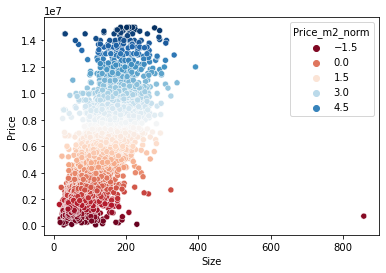

In [49]:
df['Price_m2_norm'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()

sns.scatterplot(data = df,
                x = 'Size',
                y = 'Price',
                hue='Price_m2_norm', 
                palette='RdBu',
                #alpha = 0.3
               )



The two observations around 850 and 400 m2 looks like outliers 

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'Count'}>]], dtype=object)

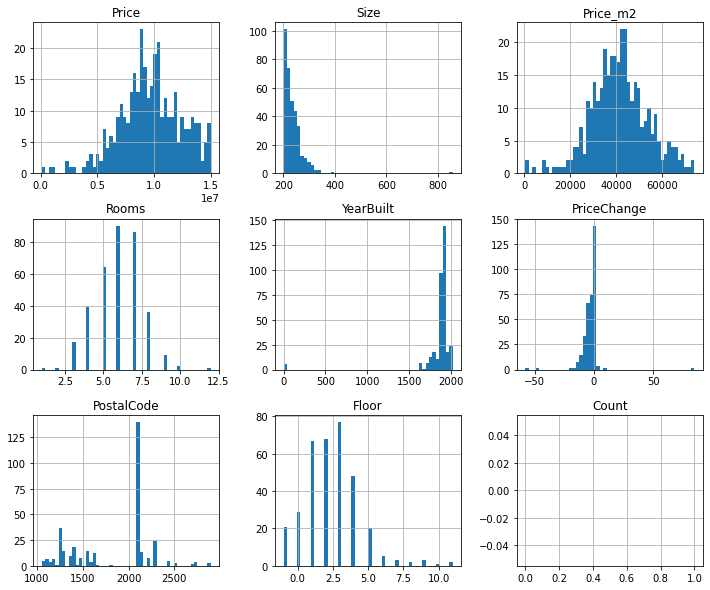

In [31]:
max_size = 200
df_ls = df[df['Size'] > max_size]


<AxesSubplot:title={'center':'Count'}, xlabel='Size', ylabel='Price'>

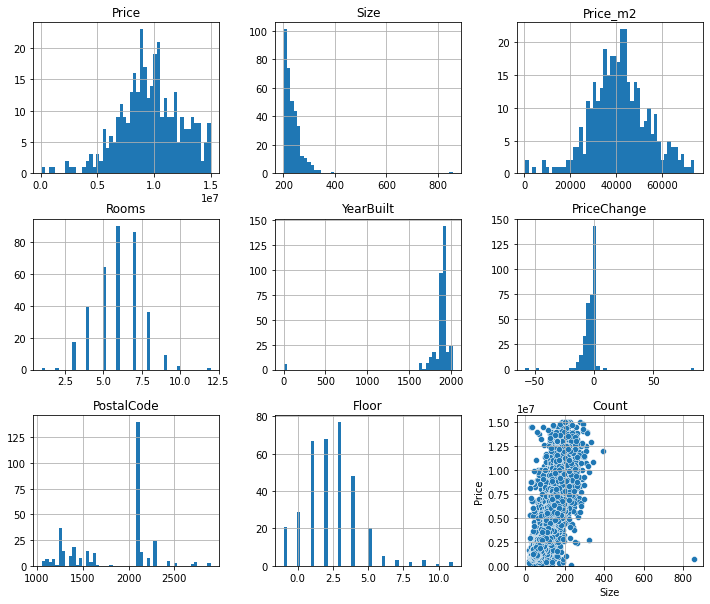

In [33]:
df_ls.hist(bins = 50,
           figsize=(12,10))





# Geographical data
To enable geographical analysis, e.g., distance to public transport, waterfront area etc., I need the geolocation of the addresses. This is possible by using DAWA (Danmarks Adressers Web API). By using the package pydawa, which is a wrapper for the API, this is quite easy.

## Geolocations for apartment addresses
Import the package and try one address

In [33]:
# Import package
import pydawa
import time

# Search for address
adresse = pydawa.Adressesoeg(q = 'Amerika Plads 6')

# Save response
response = adresse.info()

# Get coordinates (in CRS:25832)
adresse.get_koordinater(response[0])

(725829.55, 6178382.86)

Geocode all the addresses in the data frame by creating a function and applying it to a column only containing the street name and street number. To reduce the risk of any maximum number of requests per minute or hour, add a delay. (It took ca. 1-1.5 hour to run the code and geolocate all the addresses)

In [39]:
# Creat  column
df['Street'] = df['StreetAddress'].str.split(',').str[0]

# Create function
def get_lon_lat(add):
    
    adresse = pydawa.Adressesoeg(q = add)
    
    response = adresse.info()
    
    lon_lat = adresse.get_koordinater(response[0])
    
    time.sleep(0.1)
    
    return lon_lat



# Run geocoding for all addresses
lon_lat = df['Street'].apply(get_lon_lat)

Insert longitude and latitude in data frame and inspect the results

In [59]:
df[['Lon', 'Lat']] = lon_lat.values.tolist()

df.head()

,StreetAddress,Price,Date,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Floor,Street,Lon_lat,Lon,Lat
0,"Amerika Plads 6, 3. th",5000000,17-01-2022,93,53763,3,2007,-5,2100,København Ø,3,Amerika Plads 6,"(725829.55, 6178382.86)",725829.55,6178382.86
1,"Strandvejen 8, 3. tv",8495000,14-01-2022,170,49971,6,1929,0,2100,København Ø,3,Strandvejen 8,"(701140.38, 6149790.6)",701140.38,6149790.60
2,"Nørrebrogade 9F, 1. th",5400000,14-01-2022,105,51429,3,1863,-2,2200,København N,1,Nørrebrogade 9F,"(723816.79, 6177062.36)",723816.79,6177062.36
3,"Badensgade 48, 2",7200000,14-01-2022,65,110769,3,1899,0,2300,København S,2,Badensgade 48,"(727190.71, 6174651.68)",727190.71,6174651.68
4,"Badensgade 48, 1",7200000,14-01-2022,79,91139,3,1899,0,2300,København S,1,Badensgade 48,"(727190.71, 6174651.68)",727190.71,6174651.68


Write data to new file

In [ ]:
df.to_csv('Data_Boliga_20220208_cleaned_20220313.csv', index  = False)